# Estimation of ISI CVs in sequence generating network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from aux import get_c_mean_p, get_c_spd
from disp import set_plot
from ntwk import SoftmaxNtwk
from time_stats import get_isi_cv_1, get_isi_cv_2

In [2]:
D = 16

mself = np.eye(D, dtype=bool)
mseq = np.diag(np.ones(D-1), -1).astype(bool)
mseq[0, -1] = True  # periodic

t_max = 1000
t = np.arange(t_max)

In [3]:
N = 2000

In [4]:
A = np.arange(0, 2*np.pi, 2*np.pi/D)

# Variance-driven sequence network (starting from variance self-coupled network)

In [5]:
MU_J_SELF = 0
MU_J_CROSS = 0
MU_J_SEQ = 0

SGM_J_SELF = 10
SGM_J_CROSS = 1
SGM_J_SEQS = [5, 10]

ths_all = []
xs_all = []
ys_all = []

for SGM_J_SEQ in SGM_J_SEQS:
    sys.stdout.write('\n>')

    MU_J = np.nan*np.zeros((D, D))
    SGM_J = np.nan*np.zeros((D, D))

    MU_J[mself] = MU_J_SELF
    MU_J[~mself] = MU_J_CROSS
    MU_J[mseq] = MU_J_SEQ

    SGM_J[mself] = SGM_J_SELF
    SGM_J[~mself] = SGM_J_CROSS
    SGM_J[mseq] = SGM_J_SEQ

    J = np.nan*np.zeros((D, D, N, N))

    for d_to in range(D):
        for d_from in range(D):
            J[d_to, d_from, :, :] = SGM_J[d_to, d_from]*np.sqrt(D/N)*np.random.randn(N, N) + MU_J[d_to, d_from]*D/N

    ntwk = SoftmaxNtwk(J)
    
    x_0 = np.random.randn(N, D)
    x_0[:, :10] *= 5
    g = np.inf
    t, xs, ys = ntwk.run(g=g, t_max=t_max, x_0=x_0, progress=20)

    ths = ys.mean(axis=1)
        
    ths_all.append(ths)
    xs_all.append(xs.copy())
    ys_all.append(ys.copy())


>.................................................
>.................................................

In [6]:
# estimate speeds
t_start = 100
c_means = [get_c_mean_p(A, ths) for ths in ths_all]
spds = [get_c_spd(c_mean, t_start)*D/(2*np.pi) for c_mean in c_means]

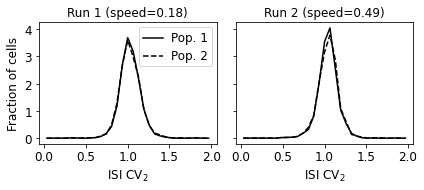

In [10]:
d_a = 0
d_b = 1

ys_0 = ys_all[0]
ys_1 = ys_all[1]

t_start = 100

get_isi_cv = get_isi_cv_2

isi_cv_a_0s = [get_isi_cv(ys_0[t_start:, i, d_a]) for i in range(N)]
isi_cv_a_1s = [get_isi_cv(ys_1[t_start:, i, d_a]) for i in range(N)]

isi_cv_b_0s = [get_isi_cv(ys_0[t_start:, i, d_b]) for i in range(N)]
isi_cv_b_1s = [get_isi_cv(ys_1[t_start:, i, d_b]) for i in range(N)]

fig, axs = plt.subplots(1, 2, figsize=(6, 2.75), tight_layout=True, sharey=True)

bins = np.linspace(0, 2, 32)
binc = .5*(bins[:-1] + bins[1:])

cts_a = np.histogram(isi_cv_a_0s, bins=bins, density=True)[0]
cts_b = np.histogram(isi_cv_b_0s, bins=bins, density=True)[0]

axs[0].plot(binc, cts_a, c='k')
axs[0].plot(binc, cts_b, c='k', ls='--')
axs[0].legend([f'Pop. 1', f'Pop. 2'])

set_plot(axs[0], x_label=f'ISI CV$_2$', y_label='Fraction of cells', title=f'Run 1 (speed={spds[0]:.2f})')

cts_a = np.histogram(isi_cv_a_1s, bins=bins, density=True)[0]
cts_b = np.histogram(isi_cv_b_1s, bins=bins, density=True)[0]

axs[1].plot(binc, cts_a, c='k')
axs[1].plot(binc, cts_b, c='k', ls='--')

set_plot(axs[1], x_label=r'ISI CV$_2$', title=f'Run 2 (speed={spds[1]:.2f})')

fig.savefig('figs/main/5_isi_seq.svg')